Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [1]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2
from torchinfo import summary
from matplotlib.colors import ListedColormap


In [2]:
batch_size = 256
learning_rate = 2e-3
num_epochs_ae = 10
num_epochs_ad = 100
latent_dim = 21
mnist_class_anomaly = 4
kernels = 8
fuzzy_rules_count = 64

prefix = f"fuzzy_ad"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

binary_cmap = ListedColormap(['yellow', 'red'], N=2)
ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)
device

device(type='cuda')

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [3]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=0), 
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [4]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [5]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [6]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

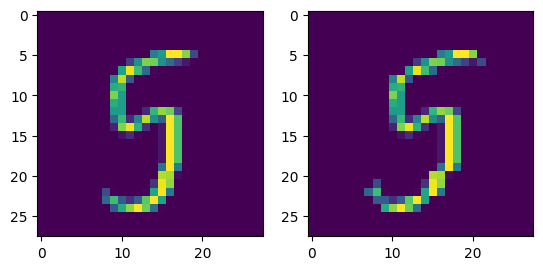

In [7]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size = 5), 
            nn.Conv2d(kernels, kernels, kernel_size = 5), 
            nn.BatchNorm2d(kernels), 
            nn.SiLU(),

            nn.Conv2d(kernels, 2*kernels, kernel_size = 5), 
            nn.Conv2d(2*kernels, 2*kernels, kernel_size = 5), 
            nn.BatchNorm2d(2*kernels), 
            nn.SiLU(),

            nn.Conv2d(2*kernels, 4*kernels, kernel_size = 5), 
            nn.Conv2d(4*kernels, 4*kernels, kernel_size = 5), 
            nn.BatchNorm2d(4*kernels), 
            nn.SiLU(),

            nn.Conv2d(4*kernels, 8*kernels, kernel_size = 4), 
            nn.BatchNorm2d(8*kernels), 
            nn.SiLU(),            
        )

        self.latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*kernels, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.Tanh()
        )
        initial_centroids = (0.5-np.random.rand(fuzzy_rules_count, latent_dim))
        initial_scales = np.ones((fuzzy_rules_count, latent_dim))

        self.fuzzy_a = nn.Sequential(
            FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales)
        )

        self.defuzzy = nn.Sequential(
            #DefuzzyLinearLayer.from_array(np.repeat(1e-1, fuzzy_rules_count).reshape(1, -1), with_norm=False, trainable=True)
            DefuzzyLinearLayer.from_dimensions(fuzzy_rules_count, 28*28, with_norm=False),
        )

    def forward(self, x):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """
        enc = self.encoder(x)
        latent = self.latent(enc)
        #pt_a, pt_b = torch.chunk(latent, 2, dim=-1)
        fz = self.fuzzy_a(latent)
        dfz = self.defuzzy(fz).reshape(-1, 1, 28, 28)
        #fz = (fz.clamp(min=0.1) - 0.1)/0.9
        #fz_b = self.fuzzy_b(pt_b)
        #fz = torch.cat((fz_a, fz_b),1)
        #fz = 1 - fz
        return fz, latent, dfz

#inp = torch.rand(10, 1, 28, 28)
m = Encoder(latent_dim, 16)
#fz, mu, dfz = m.forward(inp)

summary(m, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [256, 64]                 --
├─Sequential: 1-1                        [256, 128, 1, 1]          --
│    └─Conv2d: 2-1                       [256, 16, 24, 24]         416
│    └─Conv2d: 2-2                       [256, 16, 20, 20]         6,416
│    └─BatchNorm2d: 2-3                  [256, 16, 20, 20]         32
│    └─SiLU: 2-4                         [256, 16, 20, 20]         --
│    └─Conv2d: 2-5                       [256, 32, 16, 16]         12,832
│    └─Conv2d: 2-6                       [256, 32, 12, 12]         25,632
│    └─BatchNorm2d: 2-7                  [256, 32, 12, 12]         64
│    └─SiLU: 2-8                         [256, 32, 12, 12]         --
│    └─Conv2d: 2-9                       [256, 64, 8, 8]           51,264
│    └─Conv2d: 2-10                      [256, 64, 4, 4]           102,464
│    └─BatchNorm2d: 2-11                 [256, 64, 4, 4]        

In [9]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Decoder, self).__init__()

        self.decode = nn.Sequential(
            nn.Linear(latent_dim, 8*kernels),
            nn.BatchNorm1d(8*kernels),
            nn.Unflatten(1, (8*kernels, 1, 1)),
            
            nn.ConvTranspose2d(8*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels),
            nn.SiLU(),

            nn.ConvTranspose2d(4*kernels, 2*kernels, 5),
            nn.ConvTranspose2d(2*kernels, 2*kernels, 5),
            nn.BatchNorm2d(2*kernels),
            nn.SiLU(),

            nn.ConvTranspose2d(2*kernels, kernels, 5),
            nn.ConvTranspose2d(kernels, kernels, 5),
            nn.BatchNorm2d(kernels),
            nn.SiLU(),

            nn.ConvTranspose2d(kernels, kernels, 5),
            nn.ConvTranspose2d(kernels, 1, 5),
            nn.BatchNorm2d(1),
            nn.SiLU(),
        )
        
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """
        out = self.decode(z)
        out = out.clamp(0, 1)
        return out
    
    
# inp = torch.rand(batch_size, latent_dim)
m = Decoder(latent_dim, 16)
# mu = m.forward(inp)
# mu[0].shape

summary(m, input_size=(batch_size, latent_dim))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [256, 1, 28, 28]          --
├─Sequential: 1-1                        [256, 1, 28, 28]          --
│    └─Linear: 2-1                       [256, 128]                2,816
│    └─BatchNorm1d: 2-2                  [256, 128]                256
│    └─Unflatten: 2-3                    [256, 128, 1, 1]          --
│    └─ConvTranspose2d: 2-4              [256, 64, 4, 4]           131,136
│    └─BatchNorm2d: 2-5                  [256, 64, 4, 4]           128
│    └─SiLU: 2-6                         [256, 64, 4, 4]           --
│    └─ConvTranspose2d: 2-7              [256, 32, 8, 8]           51,232
│    └─ConvTranspose2d: 2-8              [256, 32, 12, 12]         25,632
│    └─BatchNorm2d: 2-9                  [256, 32, 12, 12]         64
│    └─SiLU: 2-10                        [256, 32, 12, 12]         --
│    └─ConvTranspose2d: 2-11             [256, 16, 16, 16]         

In [10]:
class VAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, fuzzy_rules_count, kernels):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim, kernels)        
        self.decoder = Decoder(latent_dim, kernels)
        

    def forward(self, x):
        """
        
        """
        fz, mu, dfz = self.encoder(x)
        x_recon = self.decoder(mu)
        
        return fz, mu, x_recon, dfz
    
    def half_pass(self, x):
        """
        
        """
        fz, mu, dfz = self.encoder(x)
        return fz, mu, dfz
    
    def decoder_pass(self, x):
        r = self.decoder(x)
        return r

In [11]:
model = VAE(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

summary(model, input_size=(batch_size, 1, 28, 28))

Number of parameters: 211,002


Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [256, 64]                 --
├─Encoder: 1-1                           [256, 64]                 --
│    └─Sequential: 2-1                   [256, 64, 1, 1]           --
│    │    └─Conv2d: 3-1                  [256, 8, 24, 24]          208
│    │    └─Conv2d: 3-2                  [256, 8, 20, 20]          1,608
│    │    └─BatchNorm2d: 3-3             [256, 8, 20, 20]          16
│    │    └─SiLU: 3-4                    [256, 8, 20, 20]          --
│    │    └─Conv2d: 3-5                  [256, 16, 16, 16]         3,216
│    │    └─Conv2d: 3-6                  [256, 16, 12, 12]         6,416
│    │    └─BatchNorm2d: 3-7             [256, 16, 12, 12]         32
│    │    └─SiLU: 3-8                    [256, 16, 12, 12]         --
│    │    └─Conv2d: 3-9                  [256, 32, 8, 8]           12,832
│    │    └─Conv2d: 3-10                 [256, 32, 4, 4]           25,6

### Losses

In [12]:
def compute_ae_loss(x, recon_x):
    #loss_c = ssim(x, centroid).clamp(0, 1).detach()
    loss_recon = (x-recon_x).square().sum(-1).sum(-1)#(1 - ssim(recon_x, x))#
    loss_recon = loss_recon.mean()
    return loss_recon
    

In [13]:
torch.rand(2, 10)

tensor([[0.0741, 0.8645, 0.1468, 0.7890, 0.9569, 0.5522, 0.0978, 0.6596, 0.7066,
         0.7062],
        [0.8700, 0.2555, 0.8433, 0.2046, 0.0582, 0.9643, 0.7489, 0.9231, 0.0502,
         0.2417]])

In [14]:
def compute_fuzzy_loss(fz):
    return  fz.topk(2).values.diff().mean() # +  (1 - fz.qu.max(-1)).mean() #(0.999 - (tops[:,0]+tops[:,1]).clamp(max=0.999)).mean() + tops[:, 2].clamp(min=0.001).mean()

In [15]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [16]:
def fuzzy_term_volume_loss(layer, fz):
    dfz = fz.detach().mean(0)
    
    ev = layer.get_transformation_matrix_eigenvals().real.mean(-1)
    ev = 1/ev.mean()
    
    return ev#(1 - fz.max(-1).values).abs().mean()#

In [17]:
def get_arate(inp):
    fz, mu, x_recon, dfz = model.forward(inp)
    
    return fz.sum(-1).cpu().numpy() #(1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

### Train AE

In [18]:
optimizer_ae = torch.optim.Adam(model.parameters(), lr=learning_rate)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer_ae, learning_rate, epochs=num_epochs_ae, steps_per_epoch=len(train_loader))
#sched = torch.optim.lr_scheduler.ConstantLR(optimizer_ae, learning_rate)

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        
        _, mu, _ = model.half_pass(adata)  
        x_reconstruct = model.decoder_pass(mu)
        
        loss_reconstruct = compute_ae_loss(data, x_reconstruct)
        
        loss_reconstruct.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)
        optimizer.step()  

        if sched is not None:
            sched.step()
        
    if writer is not None:
        writer.add_scalar('FAD/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [20]:
#fixed_random_z = torch.randn(16, fuzzy_rules_count).to(device)

def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 

    test_recon_loss = 0
    test_fz_loss = 0
    test_fz_sum_loss = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)

            fz, mu, dfz = model.half_pass(data)  
            x_reconstruct = model.decoder_pass(mu)
            #x_centroidal = model.decoder(F.one_hot(fz.argmax(-1), fuzzy_rules_count).float())

            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())

            loss_recon = compute_ae_loss(data, x_reconstruct)
            fz_loss = fuzzy_term_volume_loss(model.encoder.fuzzy_a[0], fz)
            
            test_recon_loss += loss_recon.item()
            test_fz_loss += fz_loss.item()
            test_fz_sum_loss += fz.sum(-1).mean()
            

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)
   
    test_recon_loss /= len(dataloader)
    test_fz_loss /= len(dataloader)
    test_fz_sum_loss /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, VOL: {test_fz_loss:.4f} SUM: {test_fz_sum_loss:.2f} AUC: {roc_auc:.4f}')
    #print(f'Average activation stats: {model.decoder.fuzzy[2].get_norm_stats()}')
    #print(f'Average centroid stats: {model.decoder.fuzzy[0].get_average_centroid()}')
    if writer is not None:
        writer.add_scalar('FAD/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('FAD/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('FAD/Fz', test_fz_loss, global_step=cur_step)
        writer.add_scalar('FAD/Sum', test_fz_sum_loss, global_step=cur_step)
        
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
        centroids_a = model.encoder.fuzzy_a[0].get_centroids().detach().cpu().numpy()
        #centroids_b = model.encoder.fuzzy_b[0].get_centroids().detach().cpu().numpy()
        ax[0].scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=2)
        ax[0].scatter(centroids_a[:, 0],      centroids_a[:, 1], marker='1', c='black', s= 50)
        ax[0].set_xlim(-1, 1)
        ax[0].set_ylim(-1, 1)
        #ax[0].scatter(centroids_b[:, 0],      centroids_b[:, 1], marker='2', c='black', s= 50)
        
        ax[1].scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=2)
        ax[1].scatter(centroids_a[:, 1],      centroids_a[:, 2], marker='1', c='black', s= 50)
        ax[1].set_xlim(-1, 1)
        ax[1].set_ylim(-1, 1)
        #ax[1].scatter(centroids_b[:, 1],      centroids_b[:, 2], marker='2', c='black', s= 50)
    
        act_fz = torch.diag(torch.ones(fuzzy_rules_count)).to(device)
        samples = model.encoder.defuzzy(act_fz)
        img_idx = 0
        fign, axn = plt.subplots(8, 1 + fuzzy_rules_count//8, figsize=(1 + fuzzy_rules_count//8, 8), squeeze=False)
        for i in range(8):
            if img_idx >= fuzzy_rules_count:
                continue
            for j in range(fuzzy_rules_count//8):
                axn[i, j].imshow(samples[img_idx].view(28, 28).cpu().detach().numpy(), cmap='gray')
                axn[i, j].axis('off')
                img_idx += 1

        writer.add_figure('FAD/Emedding', fig, global_step=cur_step)
        writer.add_figure('FAD/Samples', fign, global_step=cur_step)

In [21]:
prev_updates = 0

In [22]:
for epoch in range(num_epochs_ae):
    prev_updates = train(model, train_loader, optimizer_ae, sched, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()

[212] Reconstruction loss: 39.6550, VOL: 1.0000 SUM: 4.24 AUC: 0.6336
[424] Reconstruction loss: 34.9533, VOL: 1.0000 SUM: 2.73 AUC: 0.6773
[636] Reconstruction loss: 29.5047, VOL: 1.0000 SUM: 3.17 AUC: 0.6058
[848] Reconstruction loss: 26.7710, VOL: 1.0000 SUM: 4.63 AUC: 0.5735
[1060] Reconstruction loss: 22.0772, VOL: 1.0000 SUM: 5.45 AUC: 0.5934
[1272] Reconstruction loss: 20.2984, VOL: 1.0000 SUM: 5.84 AUC: 0.5671
[1484] Reconstruction loss: 17.9633, VOL: 1.0000 SUM: 6.40 AUC: 0.6335
[1696] Reconstruction loss: 17.8070, VOL: 1.0000 SUM: 6.58 AUC: 0.5888
[1908] Reconstruction loss: 18.9903, VOL: 1.0000 SUM: 6.32 AUC: 0.6517
[2120] Reconstruction loss: 14.5652, VOL: 1.0000 SUM: 6.38 AUC: 0.6084


### Train AD

In [23]:
params = list(model.encoder.fuzzy_a.parameters()) + list(model.encoder.latent.parameters()) + list(model.encoder.defuzzy.parameters())
optimizer_ad = torch.optim.Adam(params, lr = learning_rate)
sched_ad = torch.optim.lr_scheduler.ConstantLR(optimizer_ad, learning_rate)
#sched_ad = torch.optim.lr_scheduler.OneCycleLR(optimizer_ad, learning_rate, epochs=num_epochs_ad, steps_per_epoch=len(train_loader))

In [28]:
def train_ad(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        
        fz, mu, dfz = model.half_pass(adata)  
        x_reconstruct = model.decoder_pass(mu)
        #fz_loss = compute_fuzzy_loss(fz)
        loss_reconstruct_ae = compute_ae_loss(data, x_reconstruct)
        loss_reconstruct_ad = compute_ae_loss(data, dfz) #(loss_reconstruct_ae - dfz).square().mean() #(data - dfz).square().sum(-1).sum(-1).mean() #+ compute_ae_loss(data, x_reconstruct)

        ev_loss = keep_eigenvals_positive_loss(model.encoder.fuzzy_a[0])
        if ev_loss.item() > 0:
            ev_loss.backward(retain_graph=True)
        
        (loss_reconstruct_ad + 1e-3 * loss_reconstruct_ae).backward()
        #fz_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)
        optimizer.step()  

        if sched is not None:
            sched.step()
        
    if writer is not None:
        writer.add_scalar('FAD/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [ ]:
for epoch in range(num_epochs_ad):
    prev_updates = train_ad(model, train_loader, optimizer_ad, sched_ad, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()

[8268] Reconstruction loss: 37.8334, VOL: 0.9203 SUM: 6.10 AUC: 0.4569
[8480] Reconstruction loss: 42.4272, VOL: 0.9203 SUM: 6.09 AUC: 0.4524
[8692] Reconstruction loss: 37.6675, VOL: 0.9192 SUM: 6.11 AUC: 0.4482
[8904] Reconstruction loss: 38.0011, VOL: 0.9185 SUM: 6.50 AUC: 0.4496
[9116] Reconstruction loss: 38.9362, VOL: 0.9185 SUM: 6.40 AUC: 0.4345
[9328] Reconstruction loss: 41.0714, VOL: 0.9168 SUM: 6.41 AUC: 0.4522
[9540] Reconstruction loss: 39.0208, VOL: 0.9171 SUM: 6.53 AUC: 0.4649
[9752] Reconstruction loss: 42.1513, VOL: 0.9158 SUM: 6.58 AUC: 0.4791
[9964] Reconstruction loss: 40.7680, VOL: 0.9161 SUM: 6.54 AUC: 0.4355
[10176] Reconstruction loss: 37.1325, VOL: 0.9151 SUM: 6.80 AUC: 0.4448
[10388] Reconstruction loss: 38.3357, VOL: 0.9142 SUM: 6.80 AUC: 0.4364
[10600] Reconstruction loss: 37.3624, VOL: 0.9134 SUM: 6.87 AUC: 0.4444
[10812] Reconstruction loss: 38.9513, VOL: 0.9127 SUM: 7.00 AUC: 0.4499
[11024] Reconstruction loss: 37.9554, VOL: 0.9121 SUM: 7.04 AUC: 0.4545
[

In [ ]:
model.eval()
data = test_data[1][0].reshape(1,1,28,28).to(device)
fz, mu, x_recon, dfz = model.forward(data)
dfz - compute_ae_loss(data, x_recon) 

In [ ]:
model.encoder.defuzzy[0].Z

In [ ]:
keep_eigenvals_positive_loss(model.encoder.fuzzy_a[0])

## Визуализируем результаты

In [ ]:

def get_activation_stats(model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, _) in enumerate(tqdm(dataloader)):
            data = data.to(device)
            fz, mu, rec_x, dfz = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind in act_fz:
                rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat

train_stat = get_activation_stats(model, train_loader)
test_stat = get_activation_stats(model, test_loader)

plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

In [ ]:

def get_activation_stats_by_digit(digit, model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, target) in enumerate(tqdm(dataloader)):
        
            data = data.to(device)
            fz, mu, rec_x, dfz = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind, trg in zip(act_fz, target):
                if trg == digit:
                    rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat


test_stat_by_digit = get_activation_stats_by_digit(8, model, test_loader)

plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
plt.xlim((-1, fuzzy_rules_count + 1))

In [ ]:
test_stat_by_digit

In [ ]:
with torch.no_grad():
    act_fz = torch.diag(torch.ones(fuzzy_rules_count)).to(device)
    samples = model.encoder.defuzzy(act_fz)
    img_idx = 0
    fig, ax = plt.subplots(8, fuzzy_rules_count//8, figsize=(fuzzy_rules_count//8, 8))
    for i in range(8):
        for j in range(fuzzy_rules_count//8):
            ax[i, j].imshow(samples[img_idx].view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')
            img_idx += 1

In [ ]:
# with torch.no_grad():
#     z = torch.randn(64, fuzzy_rules_count).to(device)
#     samples = model.decoder_pass(z)

#     # Plot the generated images
#     fig, ax = plt.subplots(8, 8, figsize=(8, 8))
#     for i in range(8):
#         for j in range(8):
#             ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
#             ax[i, j].axis('off')


In [ ]:
def get_arate(inp):
    fz, mu, x_recon, dfz = model.forward(inp)
    return (1 - ssim(x_recon, inp)).cpu().numpy()#fz.sum(-1).cpu().numpy() #xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#(inp - x_recon).abs().sum(-1).sum(-1).mean(-1).cpu().numpy()#

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

In [ ]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

In [ ]:


def show_plot():
    #centroids = model.encoder.fuzzy[0].get_centroids().detach().cpu().numpy()
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            fz, mu, rec_x, dfz = model.forward(data)
            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

In [ ]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        fz, mu, rec_x, dfz = model.forward(data)
        
        plt.figure(figsize=(24, 6))

        R, C = 1, 6

        plt.subplot(R, C, 1)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 2)
        plt.imshow(rec_x[ind].detach().cpu().squeeze())
        
        plt.subplot(R, C, 3)
        plt.imshow((rec_x[ind] - data[ind]).abs().detach().cpu().squeeze())
        break

In [ ]:
show_item_reconstructio(4)
show_item_reconstructio(3)

In [ ]:
threshold = optimal_threshold
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc='EMNIST VIS'):
        if n >= 100:
            break
        data = data.view((-1, 1, 28, 28)).to(device) 
        
        arate = get_arate(data)
        
        for i in range(data.shape[0]):
            if(arate[i] > threshold):
                img = data[i]
                ax[int(n / 10), int(n % 10)].imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
                ax[int(n / 10), int(n % 10)].axis('off')
                n = n + 1
                    
                if n >= 100:
                    break